In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster
from core.utils import used_keys

In [2]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'
model_params = '_75_0_None_None_False'
clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          'licBAD', 'misBAD',
    'ssbCCM','ssbCCD'    
]


linkage = 'complete'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [3]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar, read_extra=False):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)


    if read_extra:
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        vals = scalar.fit_transform(extra_chars)
        extra_chars = pd.DataFrame(vals, columns=extra_chars.columns, index=extra_chars.index).fillna(0)
        extra_chars = extra_chars.drop(component_data.columns[component_data.std() == 0], axis=1)
        extra_chars = extra_chars[['limLPS']]
        extra_chars['limLPS2'] = extra_chars['limLPS']

        merged_data = pd.merge(component_data, extra_chars, how='inner', left_index=True, right_index=True)
        pd.testing.assert_index_equal(merged_data.index, component_data.index)
        component_data = merged_data
    
    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id, scalar=StandardScaler())
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def read_morphotopes_chars():
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        data.append(extra_chars)
    
    data = pd.concat(data)
    return data 

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [4]:

regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

In [5]:
from sklearn.preprocessing import StandardScaler, QuantileTransformer
scalar = QuantileTransformer(subsample=None, output_distribution='uniform')

In [6]:
# # %%time

# ## generate and save linkage matricies for each region
# for region_id, _ in region_hulls.iterrows():
#     data = read_region_morphotope_data(region_id, scalar, read_extra=True)
#     linkage_matrix = get_morphotope_linkage(data)
#     np.save(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}', linkage_matrix)

### Setup regional cutoff to merge regional morphotopes

In [7]:
regional_cutoff = 2.5

In [8]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4
processing 10
processing 132
processing 134
processing 286
processing 313
processing 400
processing 523
processing 765
processing 801
processing 832
processing 913
processing 960
processing 1124
processing 1154
processing 1387
processing 1478
processing 1515
processing 1605
processing 1718
processing 1736
processing 1782
processing 1970
processing 1981
processing 2096
processing 2322
processing 2350
processing 2478
processing 2514
processing 2625
processing 2728
processing 2975
processing 3039
processing 3109
processing 3150
processing 3221
processing 3250
processing 3526
processing 3610
processing 3612
processing 3701
processing 3705
processing 3752
processing 3759
processing 3981
processing 4070
processing 4214
processing 4215
processing 4235
processing 4284
processing 4356
processing 4382
processing 4723
processing 4805
processing 5096
processing 5191
processing 5246
processing 5310
processing 5408
processing 5427
processing 5662
processing 5671
processing 5766
processi

In [9]:
np.unique(regional_clusters).shape

(66494,)

In [10]:
# why are these different  - 

In [182]:
# %%time
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
morphotopes_data = morphotopes_data.iloc[:, :-1]

In [183]:
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)
# component_data['sdbCoA'] = morphotopes_data.loc[:, 'sdbCoA']['mean']

In [184]:
%%time
morph_chars_data = read_morphotopes_chars()
morph_chars_data = morph_chars_data[['limLPS']]


merged_data = pd.merge(component_data, morph_chars_data, how='inner', left_index=True, right_index=True)
pd.testing.assert_index_equal(merged_data.index, component_data.index)
component_data = merged_data

CPU times: user 1.08 s, sys: 304 ms, total: 1.39 s
Wall time: 985 ms


In [185]:
component_data.loc[['93167_1802_0' , '91011_895_0']]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS
93167_1802_0,125.845496,47.872983,0.0,0.537625,6.0,0.372616,0.974698,0.663602,0.0,0.0,...,50.821931,0.681935,0.963679,0.540910,17.738801,2.728918,2.728918,77.438724,88.052753,1.0
91011_895_0,146.647818,54.164526,0.0,0.515053,4.0,0.578495,0.998408,0.629821,0.0,0.0,...,55.410041,0.621665,1.001599,0.523915,20.582737,2.793874,2.793874,147.467742,150.848301,1.0


In [186]:
grouped_data = component_data.groupby(regional_clusters).agg('median').fillna(0)
grouped_data = grouped_data.drop(grouped_data.columns[grouped_data.std() == 0], axis=1)

In [187]:
grouped_data.loc[['93167_159' , '91011_76']]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS
93167_159,110.909878,45.151081,0.0,0.550615,6.0,0.630241,0.970515,0.738956,0.0,0.0,...,49.125985,0.728091,0.965074,0.548232,17.640081,2.641372,2.641372,57.185507,58.356939,1.0
91011_76,136.005849,51.920073,0.0,0.509174,4.0,0.821341,0.995693,0.663834,0.0,0.0,...,55.618098,0.642422,0.996976,0.498945,20.342171,2.776168,2.776168,100.048444,102.965102,1.0


<Axes: ylabel='Frequency'>

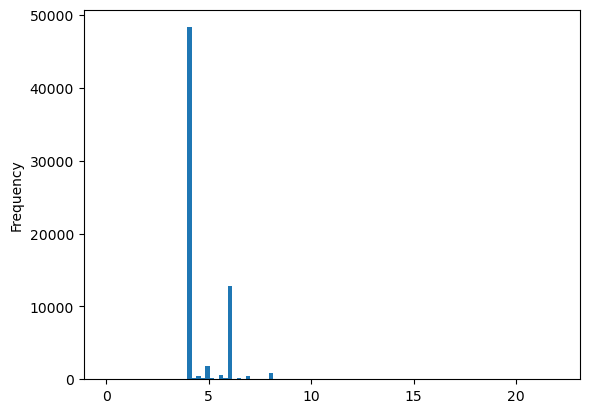

In [188]:
grouped_data.ssbCor.plot.hist(bins=100)

In [240]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
vals = scalar.fit_transform(grouped_data)
regional_ward_morphotopes_data = pd.DataFrame(vals, index=grouped_data.index, columns=grouped_data.columns)

regional_ward_morphotopes_data.loc[grouped_data['limLPS'] == 1, 'limLPS'] = 2

In [241]:
regional_ward_morphotopes_data.loc[['93167_159' , '91011_76', '69333_179']]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS
93167_159,0.576278,0.678162,-0.003878,0.126992,1.457527,0.066072,-1.477216,0.830937,-0.930174,-0.073819,...,-0.181517,0.829667,0.554162,0.889968,-0.342951,-0.244149,-0.244149,-0.136021,-0.247615,2.0
91011_76,1.099949,1.350454,-0.003878,-1.080935,-0.544985,0.157445,0.183399,-0.155199,-0.930174,-0.073819,...,-0.146166,0.022774,0.830887,0.296214,-0.233768,-0.080452,-0.080452,0.019046,-0.064579,2.0
69333_179,9.864410,7.339213,-0.003878,-3.692230,0.456271,0.045745,-3.131234,-1.988120,-0.930174,-0.073819,...,0.259991,-1.152848,0.230155,-0.642648,0.889081,2.434666,2.434666,1.958408,0.729306,2.0


In [242]:
from scipy.spatial.distance import pdist

first, second, third = ['93167_159' , '91011_76', '69333_179']

pdist(regional_ward_morphotopes_data.loc[[first, second, third]])

array([ 4.3566632 , 16.36468837, 15.52493095])

In [243]:
x,y,z = regional_ward_morphotopes_data.loc['93167_159'], regional_ward_morphotopes_data.loc['91011_76'], regional_ward_morphotopes_data.loc['69333_179']

In [244]:
regional_ward_morphotopes_data.loc[[first, second, third], 'libNCo']

93167_159   -0.073819
91011_76    -0.073819
69333_179   -0.073819
Name: libNCo, dtype: float64

In [245]:
from sklearn.cluster import KMeans

In [246]:
class DivisiveClustering:
    def __init__(self):
        self.labels_ = None
        self.linkage_matrix = None
        self.current_id = 0

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        self.linkage_matrix = []
        self.current_id = n_samples
        
        # Start with all points in one cluster, initial recursion_level is 1
        self._recursive_split(X, np.arange(n_samples), 1)
        
        self.linkage_matrix = np.array(self.linkage_matrix)
        return self

    def _recursive_split(self, X, indices, recursion_level):
        if len(indices) <= 1:
            return indices[0], 1
        
        kmeans = KMeans(n_clusters=2, random_state=123, n_init=500)
        kmeans.fit(X[indices])
        
        mask0 = kmeans.labels_ == 0
        mask1 = kmeans.labels_ == 1
        indices0 = indices[mask0]
        indices1 = indices[mask1]
        
        id0, size0 = self._recursive_split(X, indices0, recursion_level + 1)
        id1, size1 = self._recursive_split(X, indices1, recursion_level + 1)
        
        # Use 1/recursion_level as distance
        distance = 1.0 / recursion_level
        
        self.linkage_matrix.append([float(min(id0, id1)), float(max(id0, id1)), 
                                  float(distance), float(size0 + size1)])
        
        current_cluster = self.current_id
        self.current_id += 1
        return current_cluster, size0 + size1

In [247]:
clusterer = DivisiveClustering()

In [248]:
# cluster_data = regional_ward_morphotopes_data[(regional_ward_morphotopes_data.index.str.startswith('69333') | 
#                                                regional_ward_morphotopes_data.index.str.startswith('91011') | 
#                                                regional_ward_morphotopes_data.index.str.startswith('93167'))]

cluster_data = regional_ward_morphotopes_data.copy()




In [249]:
%%time
clusterer.fit(cluster_data.values)

CPU times: user 1min 22s, sys: 18.3 s, total: 1min 40s
Wall time: 52 s


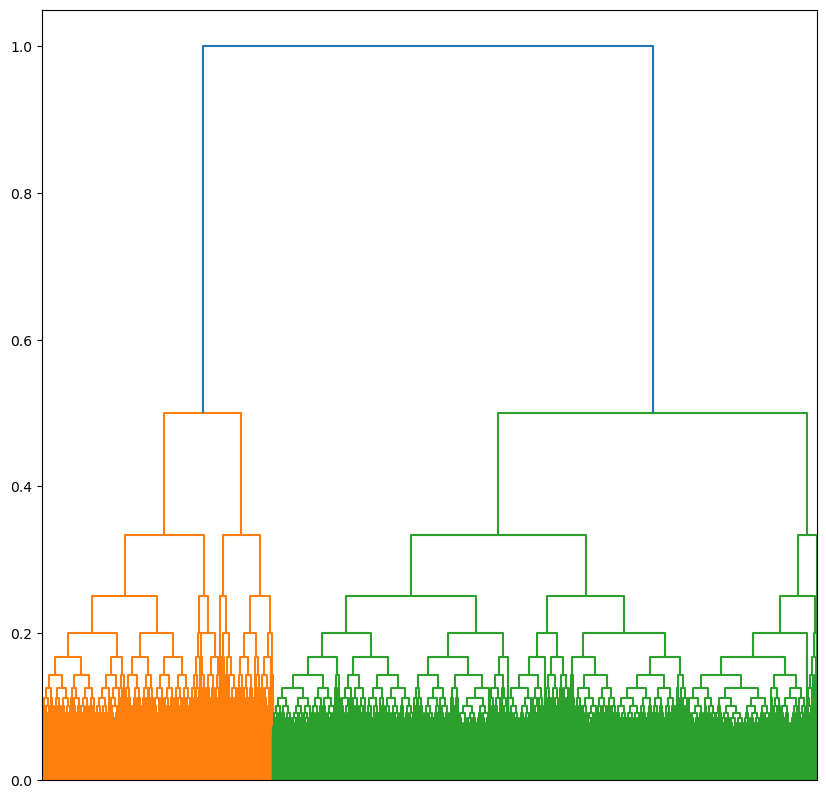

In [250]:
## final dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(clusterer.linkage_matrix, ax=ax, no_labels=True)

In [289]:
final_cutoff = 1/6 -0.00001
clusters = fcluster(clusterer.linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, cluster_data.index)
final_clusters.value_counts()

49    7087
33    5278
47    5181
36    4033
46    3508
38    3356
37    3117
41    3111
50    3099
1     2454
35    2308
2     2174
3     1990
7     1782
39    1608
5     1421
8     1411
43    1246
6     1045
48    1038
26     928
29     891
44     887
9      777
24     760
15     715
53     693
13     534
25     497
4      476
45     442
34     405
16     391
28     348
22     318
23     246
32     179
27     173
54     143
20      97
10      83
21      71
31      69
40      55
55      19
19      19
17      12
30       5
42       4
51       1
57       1
11       1
58       1
14       1
12       1
52       1
18       1
56       1
59       1
Name: count, dtype: int64

### Plotting

In [290]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [255,255,255]

In [291]:
region_id = 69333 

# region_id = 99886 # bratislava

# region_id = 151676 # vilnius

# region_id = 8707 # mainz/frankfurt
# region_id = 5883 #  freiburg
# region_id = 38679 #munich
# region_id = 55763 # berlin

# region_id = 86873 # vienna

# region_id = 107131 # krakow


# region_id= 66593

# region_id = 91011

# region_id = 8707

# region_id = 62954 # lindz


In [292]:
# etcs=False to read buildings, etcs=True for tessellation cells.


etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [293]:
etcs = morphotopes_to_etcs(69333, etcs=False, model_params=model_params)
etcs2 = morphotopes_to_etcs(91011, etcs=False, model_params=model_params)
etcs3 = morphotopes_to_etcs(93167, etcs=False, model_params=model_params)

etcs = pd.concat((etcs, etcs2, etcs3), ignore_index=True)

In [294]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")



In [295]:
# ## can run this to change colors on an exisitng layer
# layer.get_fill_color = get_color(etcs.final)

In [296]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [297]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 2.04 s, sys: 269 ms, total: 2.31 s
Wall time: 2.3 s


In [298]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters - {final_cutoff}')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)
    

In [299]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [478]:
linkage_matrix = clusterer.linkage_matrix

In [479]:
from core import interactive_dendrogram
import jscatter
import ipywidgets

scatter_df = interactive_dendrogram.get_dendrogram_scatter_data(linkage_matrix)
n = linkage_matrix.shape[0] + 1

def get_subcluster_children(focus):
    child, parent = linkage_matrix[focus - n, 0].astype(int), linkage_matrix[focus - n, 1].astype(int)
    children_ids = interactive_dendrogram.get_children(linkage_matrix, child, parent)
    children_morphotopes = regional_ward_morphotopes_data.iloc[children_ids].index
    return children_morphotopes

click_history = dict()
click_history_descriptions = dict()

In [482]:
scatter = jscatter.Scatter(data=scatter_df, x='x', y='y', height=640, width=1280)
scatter.axes(grid=True)
scatter.connect(by='group1', order='order1')
scatter.options({ 'pointConnectionTolerance': 1 })

# output = ipywidgets.Output()

# @output.capture(clear_output=True)
# def selection_change_handler(change):
#     display(scatter_df.loc[change.new].style.hide(axis='index'))
            
# scatter.widget.observe(selection_change_handler, names=["selection"])

# ipywidgets.HBox([scatter.show(), output])

In [483]:
scatter.show()

In [476]:
selected_node = scatter.selection()[0]


left = scatter_df.loc[selected_node, 'child'].astype(int)
right = scatter_df.loc[selected_node, 'parent'].astype(int)

left_children = get_subcluster_children(left)
right_children = get_subcluster_children(right)

cluster_colors = np.full((etcs.shape[0], 3), 0) # everything black
cluster_colors[etcs.regional.isin(left_children)] = [141,211,199] # left blue - 1
cluster_colors[etcs.regional.isin(right_children)] = [255,255,179] # right yellow - 2
layer.get_fill_color = cluster_colors.astype('uint8')

In [432]:
left_data = regional_ward_morphotopes_data.loc[left_children].mean()
right_data = regional_ward_morphotopes_data.loc[right_children].mean()
# assert np.isclose(pd.DataFrame({1:left_data, 2: right_data}).T.values, clusters_description.values).all()

diffs = (left_data - right_data)
diffs = diffs[(diffs ** 2).sort_values(ascending=False).index].head(20)
diffs

mtdDeg   -2.008590
linWID    1.620166
sdsSPO   -1.578583
mtbSWR    1.463171
ltcBuA   -1.353060
mtbNDi   -1.281014
mtbAli   -1.066860
sdsSPW   -1.039289
sdcAre   -1.037840
sdcLAL   -1.035507
sscERI   -1.034659
ldsAre   -1.024181
ldsMSL   -1.022198
midAre   -1.019047
mibERI   -0.906347
mdcAre   -0.904416
sscCCo   -0.851772
lddNDe    0.830976
mtcWNe    0.828024
midRea   -0.819065
dtype: float64

In [433]:
selected_node

np.uint32(132985)

In [434]:
used_keys['ldsRea']

'reached ETCs by local street network'

In [457]:
## save for cutting...
click_history[selected_node] = diffs

In [458]:
click_history_descriptions[selected_node] = f'{region_id} seperate smaller blocks and villages'

In [459]:
click_history_descriptions

{np.uint32(31798): 'seperate rowhouses and vinohrady',
 np.uint32(29569): 'seperate smaller structures and vinohrady',
 np.uint32(124136): 'seperate smaller blocks and smaller industry',
 np.uint32(39767): '55763 seperate smaller blocks and smaller industry in germany',
 np.uint32(115401): '69333 seperate smaller blocks and villages',
 np.uint32(46460): '66593 seperate smaller blocks and villages',
 np.uint32(125887): '151676 seperate smaller blocks and villages'}

In [37]:
click_history_descriptions = {np.uint32(31798): 'seperate rowhouses and vinohrady',
 np.uint32(29569): 'seperate smaller structures and vinohrady',
 np.uint32(124136): 'seperate smaller blocks and smaller industry',
 np.uint32(39767): '55763 seperate smaller blocks and smaller industry in germany',
 np.uint32(115401): '69333 seperate smaller blocks and villages',
 np.uint32(46460): '66593 seperate smaller blocks and villages',
 np.uint32(125887): '151676 seperate smaller blocks and villages'}

In [38]:
## assign clusters

In [39]:
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)

grouping = pd.DataFrame()
grouping[final_cutoff] = final_clusters.astype(str)

In [40]:


# for selected_node in [6421, 6887, 28557, 15017, 35908]: - hierarchy without lithuania


for selected_node in click_history_descriptions.keys():
    left = scatter_df.loc[selected_node, 'child'].astype(int)
    right = scatter_df.loc[selected_node, 'parent'].astype(int)
    
    left_children = get_subcluster_children(left)
    right_children = get_subcluster_children(right)
    
    grouping.loc[left_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '1'
    grouping.loc[right_children, round(scatter_df.loc[selected_node, 'dist'], 2)] = str(selected_node) + '2'

In [41]:
ordered_columns = grouping.columns.sort_values()
grouping = grouping[ordered_columns]

# forward cluster breakdowns to higher levels
for i, col in enumerate(ordered_columns[:-1]):
    grouping.iloc[grouping[col].notna().values, i + 1] = grouping.loc[grouping[col].notna(), col]  

In [42]:
merged_clusters = grouping[final_cutoff]
merged_clusters.factorize()

(array([ 0,  1,  2, ..., 22,  7,  7]),
 Index(['13', '14', '7', '6', '11', '317982', '24', '3', '2', '8', '5', '17',
        '21', '25', '1258872', '23', '464601', '1154012', '1241362', '16',
        '295691', '1', '295692', '4', '18', '1241361', '15', '10', '1258871',
        '464602', '9', '20', '397672', '397671'],
       dtype='object'))

In [465]:

merged_clusters = pd.Series(merged_clusters.factorize()[0], merged_clusters.index)

In [466]:
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [467]:
colorcodes = etcs['regional'].map(merged_clusters.to_dict()).fillna(-1)
layer.get_fill_color = merged_colors.loc[colorcodes].values.astype('uint8')

In [468]:
click_history_descriptions

{np.uint32(31798): 'seperate rowhouses and vinohrady',
 np.uint32(29569): 'seperate smaller structures and vinohrady',
 np.uint32(124136): 'seperate smaller blocks and smaller industry',
 np.uint32(39767): '55763 seperate smaller blocks and smaller industry in germany',
 np.uint32(115401): '69333 seperate smaller blocks and villages',
 np.uint32(46460): '66593 seperate smaller blocks and villages',
 np.uint32(125887): '151676 seperate smaller blocks and villages'}

In [469]:
scatter_df.loc[click_history_descriptions.keys()]

,child,parent,dist,size,x,y,group1,order1
31798,132691.0,132918.0,1.819189,2692.0,5.975272e+05,1.819189,66443.0,2
29569,132013.0,132641.0,0.946188,463.0,5.866530e+05,0.946188,66443.0,3
124136,132544.0,132880.0,1.797646,965.0,1.141552e+06,1.797646,66477.0,3
39767,132211.0,132332.0,0.857903,557.0,7.885529e+05,0.857903,66116.0,2
115401,132879.0,132939.0,1.887804,3016.0,9.359880e+05,1.887804,66474.0,1
46460,132727.0,132833.0,1.370760,568.0,9.230535e+05,1.370760,66449.0,3
125887,132758.0,132815.0,1.600071,1058.0,1.175755e+06,1.600071,66438.0,1


In [470]:
merged_clusters.value_counts().sort_index()

0     2304
1     4443
2     3036
3     1437
4     3061
5     2229
6     3280
7     2568
8     1067
9     3655
10    2705
11    2713
12    5131
13    2270
14     560
15    2237
16     351
17    2448
18     665
19     850
20     262
21     836
22     201
23    3291
24    2646
25     300
26     580
27    3142
28     498
29     217
30    4314
31    2640
32     354
33     203
Name: count, dtype: int64

In [477]:
v = 'v2'

In [478]:
pd.Series(click_history_descriptions).to_csv(f'/data/uscuni-ulce/processed_data/clusters/manual_cuts_{v}.csv')

In [479]:
merged_clusters.to_frame().to_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{v}.pq')

In [480]:
final_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{v}.pq')[0]
cdata = grouped_data.groupby(final_clusters).median().fillna(0)
cdata.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/cdata_{v}.pq')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/pandas/io/parquet.py:480: UserWarning: The DataFrame has non-str index name `[np.int64(0)]` which will be converted to string and not roundtrip correctly.
  impl.write(


In [405]:
from core.cluster_validation import get_color
merged_colors = pd.DataFrame(get_color(merged_clusters.values), merged_clusters.values).drop_duplicates()
merged_colors.loc[-1] = [255,255,255]

In [406]:
region_id = 151676

In [407]:
# etcs=False to read buildings, etcs=True for tessellation cells.
etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
etcs.shape

(321417, 16)

In [408]:
# region_hulls.explore()

In [409]:



## relabel
### regional_clusters = morphotopes -> regional_clusters
### final_clusters = regional_clusters -> final_clusters
etcs['final'] = etcs['morph'].map(lambda x: merged_clusters.loc[regional_clusters.loc[x]] if x in regional_clusters else -1)
etcs['regional'] = etcs['morph'].map(lambda x: regional_clusters.loc[x] if x in regional_clusters else "-1")

In [410]:
# etcs['final'] = etcs.final.map(final_clusters).values

In [411]:
region_hulls

,convex_hull
labels,
4,"POLYGON ((4122200 3045600, 4121500 3045900, 40..."
10,"POLYGON ((4068900 3057300, 4051000 3064300, 40..."
132,"POLYGON ((4053100 3049800, 4050900 3053000, 40..."
134,"POLYGON ((4052500 3093600, 4052200 3093700, 40..."
286,"POLYGON ((4060600 3103900, 4057000 3104200, 40..."
...,...
149997,"POLYGON ((5253200 3642300, 5245600 3647000, 52..."
150044,"POLYGON ((5265700 3578300, 5263400 3578400, 52..."
151676,"POLYGON ((5285400 3549200, 5284800 3549900, 52..."


In [412]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

from core.cluster_validation import get_color
layer.get_fill_color = merged_colors.loc[etcs.final].values.astype('uint8')

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


CPU times: user 1.63 s, sys: 199 ms, total: 1.83 s
Wall time: 1.81 s


In [413]:
# layer.get_fill_color = get_color(etcs.final.map(final_clusters).values.astype(int))

In [414]:
etcs.final.nunique()

17

In [780]:
etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/{region_id}_clusters.pq')

In [403]:
merged_colors.shape

(33, 3)